In [1]:
# boiler plate to allow running in colab, can ignore if running locally
import subprocess
try:
    import tailnflows
except ModuleNotFoundError:
    # need to build environment
    print('installing tailnflows environment...')
    subprocess.run(['pip', 'install', 'git+https://github.com/Tennessee-Wallaceh/tailnflows'])
    import tailnflows
    from tailnflows.utils import configure_colab_env
    configure_colab_env() # can take a while
    import torch
    torch.set_default_device('cuda')

In [2]:
import torch
import matplotlib.pyplot as plt
from tailnflows.models.flows import get_model, ModelName, ModelUse
from tailnflows.targets.heavy_tailed_nuisance import log_density, generate_data
from tailnflows.plot_utils import plot_contour

/home/th17628/miniconda3/envs/tailnflows/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


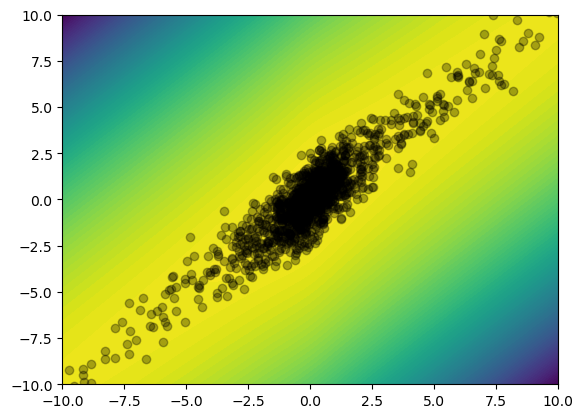

In [3]:
# sense check data + distribution
target_df = 1.

x_trn = generate_data(1300, 2, target_df)
x_val = generate_data(650, 2, target_df)
x_tst = generate_data(3000, 2, target_df)

fig, ax = plt.subplots(1, 1)
plot_contour(
    ax, 
    lambda x: log_density(x,target_df), 
    x_trn.shape[1], 
    target_x_0=-2,
    target_x_1=-1,
    min=-10,
    max=10,
    num_levels=100
)
ax.scatter(x_trn[:, 0], x_trn[:, 1], alpha=0.3, c='black')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
plt.show()

### Model: TTF_m

normal -> auto reg RQS -> auto reg affine -> tail marginal

In [8]:
from tailnflows.models.flows import TTF_m
from tailnflows.train.data_fit import train

dim = 2
tails = torch.tensor([1 / target_df, 1 / target_df])

flow = TTF_m(
    dim,
    ModelUse.density_estimation,
    model_kwargs=dict(
        tail_bound=5.,
        rotation=False,
        num_bins=3,
        pos_tail_init=tails,
        neg_tail_init=tails,
        fix_tails=True,
    ),
)

fit_data = train(flow, x_trn, x_val, x_tst, lr=5e-3, num_epochs=300, batch_size=100, label='')

100%|██████████| 300/300 [00:13<00:00, 23.06it/s, loss=4.17 (4.05) : *4.073 @ 284]


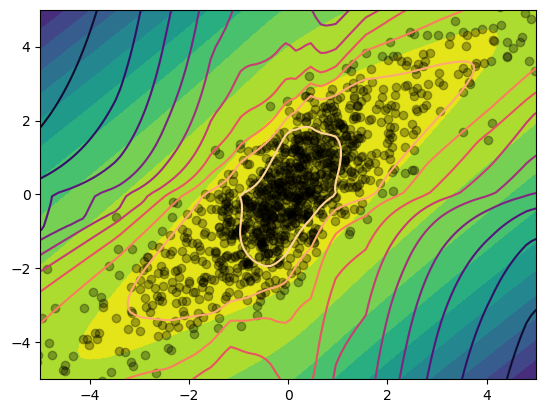

In [9]:
fig, ax = plt.subplots(1, 1)
plot_contour(ax, lambda x: log_density(x,target_df), x_trn.shape[1], target_x_0=-2, target_x_1=-1)
plot_contour(ax, lambda x: flow.log_prob(x).detach(), x_trn.shape[1], target_x_0=-2, target_x_1=-1, contour_type='line')
ax.scatter(x_trn[:, 0], x_trn[:, 1], alpha=0.3, c='black')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.show()

### Model: TTF_m_hybrid

normal -> auto reg RQS -> auto reg affine + tail marginal

In [10]:
from tailnflows.models.flows import TTF_m_hybrid

dim = 2
tails = torch.tensor([1 / target_df, 1 / target_df])

flow = TTF_m_hybrid(
    dim,
    ModelUse.density_estimation,
    model_kwargs=dict(
        tail_bound=5.,
        rotation=False,
        num_bins=3,
        pos_tail_init=tails,
        neg_tail_init=tails,
        fix_tails=True,
    ),
)

fit_data = train(flow, x_trn, x_val, x_tst, lr=5e-3, num_epochs=100, batch_size=100, label='')

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (100) must match the size of tensor b (2) at non-singleton dimension 1

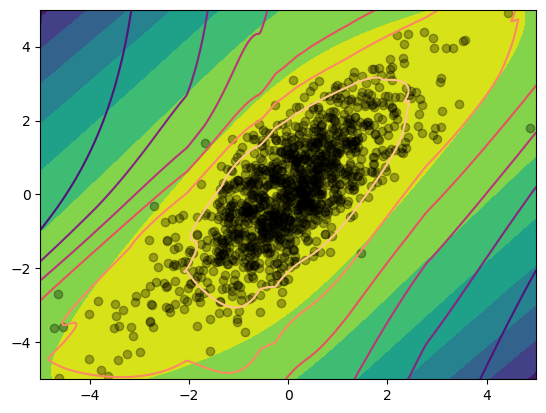

In [62]:
fig, ax = plt.subplots(1, 1)
plot_contour(ax, lambda x: log_posterior(x,target_df), x_trn.shape[1], target_x_0=-2, target_x_1=-1)
plot_contour(ax, lambda x: flow.log_prob(x).detach(), x_trn.shape[1], target_x_0=-2, target_x_1=-1, contour_type='line')
ax.scatter(x_trn[:, -2], x_trn[:, -1], alpha=0.3, c='black')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.show()

### Model: MTAF

In [11]:
from tailnflows.models.flows import mTAF
dim = 2
dfs = torch.tensor([target_df, target_df])

flow = mTAF(
    dim,
    ModelUse.density_estimation,
    model_kwargs=dict(
        tail_bound=5.,
        rotation=False,
        num_bins=3,
        tail_init=dfs,
        fix_tails=True,
    ),
)

fit_data = train(flow, x_trn, x_val, x_tst, lr=1e-3, num_epochs=500, batch_size=100, label='')

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:29<00:00, 16.85it/s, loss=4.71 (4.46) : *4.328 @ 347]


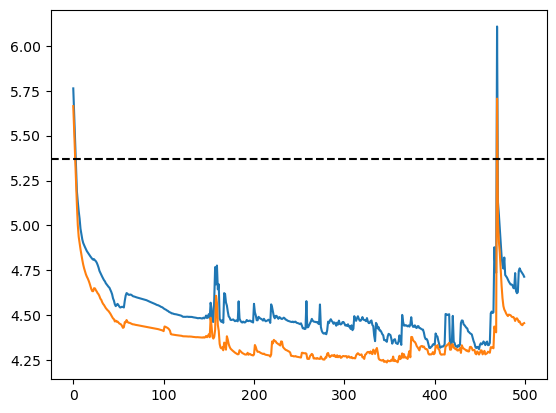

In [17]:
with torch.no_grad():
    losses = fit_data[-3]
    vlosses = fit_data[-2]

    plt.plot(losses)
    plt.plot(vlosses)
    plt.axhline(5.37, linestyle='--', c='black')

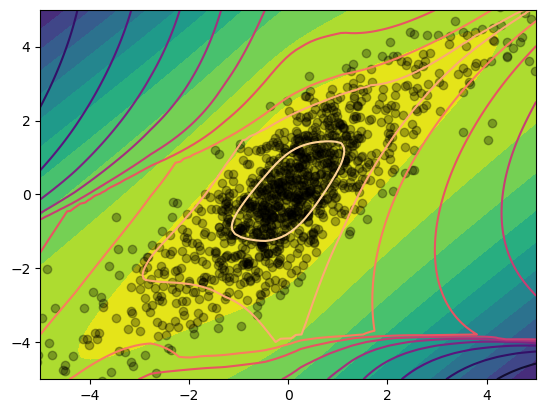

In [18]:
fig, ax = plt.subplots(1, 1)
plot_contour(ax, lambda x: log_density(x,target_df), x_trn.shape[1], target_x_0=-2, target_x_1=-1)
plot_contour(ax, lambda x: flow.log_prob(x).detach(), x_trn.shape[1], target_x_0=-2, target_x_1=-1, contour_type='line')
ax.scatter(x_trn[:, -2], x_trn[:, -1], alpha=0.3, c='black')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.show()

In [19]:
from tailnflows.models.flows import COMET

dim = 2

flow = COMET(
    dim,
    x_trn,
    ModelUse.density_estimation,
    model_kwargs=dict(
        tail_bound=5.,
        rotation=False,
        num_bins=8,
        fix_tails=True,
        tail_init=[target_df, target_df]
    ),
)

fit_data = train(flow, x_trn, x_val, x_tst, lr=1e-3, num_epochs=500, batch_size=100, label='')

100%|██████████| 500/500 [01:15<00:00,  6.59it/s, loss=4.09 (4.00) : *inf @ 490]


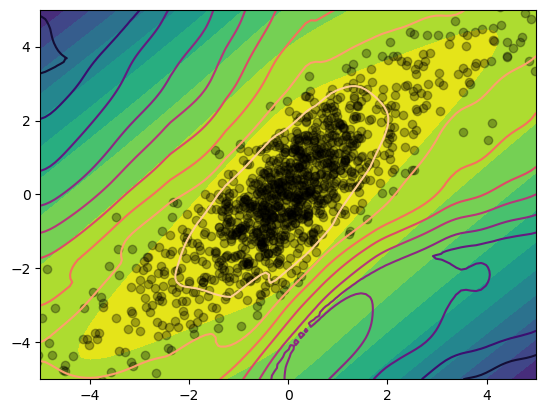

In [22]:
fig, ax = plt.subplots(1, 1)
plot_contour(ax, lambda x: log_density(x,target_df), x_trn.shape[1], target_x_0=0, target_x_1=1)
plot_contour(ax, lambda x: flow.log_prob(x).detach(), x_trn.shape[1], target_x_0=0, target_x_1=1,contour_type='line')
ax.scatter(x_trn[:, -2], x_trn[:, -1], alpha=0.3, c='black')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.show()